# Análisis de Contornos Contextuales con QSub

Este notebook demuestra el uso completo del módulo QSub para extraer y analizar contornos contextuales desde Wikipedia, incluyendo visualizaciones detalladas que muestran cómo varía el significado de una palabra en diferentes contextos.

## Objetivos:
1. **Extracción**: Obtener múltiples instancias contextuales de una palabra desde Wikipedia
2. **Análisis**: Calcular similaridades entre diferentes contextos  
3. **Visualización**: Crear gráficos que muestren la variación semántica
4. **Interpretación**: Describir patrones en el contorno contextual

---

In [9]:
# Configuración del entorno
import sys
import os
sys.path.append('..')

# Imports principales
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import importlib

# Módulo QSub
from QSub import contours

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Entorno configurado correctamente")

Entorno configurado correctamente


## 1. Extracción del Contorno Contextual

Vamos a extraer todas las instancias contextuales de una palabra desde Wikipedia. Elegiremos una palabra con significados variados para observar mejor la variación semántica.

In [ ]:
# Recargar módulo para asegurar versión actualizada
importlib.reload(contours)

# Palabra de ejemplo: "bank" (tiene múltiples significados: banco financiero, orilla de río)
target_word = "palestine"

print(f"Extrayendo contorno contextual para: '{target_word}'")
print("Esto puede tomar unos segundos...")

# Extraer contorno completo desde Wikipedia
contour_data = contours.get_complete_contextual_contour_wikipedia(
    word=target_word,
    model_name="bert-base-uncased",
    max_contexts=None,  # Extraer TODOS los contextos disponibles
    include_static=True,
    verbose=True
)

if contour_data:
    print(f"\nExtracción exitosa!")
    print(f"Total de vectores contextuales: {len([k for k in contour_data.keys() if k != 'static_vector'])}")
    if 'static_vector' in contour_data:
        print("Vector estático incluido")
else:
    print("Error en la extracción")

Extrayendo contorno contextual para: 'palestine'
Esto puede tomar unos segundos...
Querying Wikipedia API for: palestine
API URL: https://en.wikipedia.org/w/api.php
Params: {'action': 'query', 'prop': 'extracts', 'explaintext': True, 'titles': 'palestine', 'format': 'json'}
Headers: {'User-Agent': 'QSub/1.0 (https://github.com/alejandrommingo/QSub; contact@example.com) Python/requests'}
Response status: 200
Response headers: {'date': 'Sat, 06 Sep 2025 09:22:23 GMT', 'server': 'mw-api-ext.eqiad.main-566b8ff567-g7l2m', 'x-content-type-options': 'nosniff', 'content-security-policy': "default-src 'self'; script-src 'none'; object-src 'none'", 'x-frame-options': 'DENY', 'content-disposition': 'inline; filename=api-result.json', 'cache-control': 'private, must-revalidate, max-age=0', 'content-type': 'application/json; charset=utf-8', 'content-encoding': 'gzip', 'age': '0', 'vary': 'Accept-Encoding,X-Subdomain,Treat-as-Untrusted,X-Forwarded-Proto,Cookie,Authorization', 'x-cache': 'cp6011 miss

In [ ]:
# Análisis estadístico del contorno
if contour_data:
    analysis_results = contours.analyze_contextual_contour(
        contour_dict=contour_data,
        target_word=target_word,
        include_static=True
    )
    
    if analysis_results:
        print("=== ANÁLISIS ESTADÍSTICO DEL CONTORNO CONTEXTUAL ===")
        print(f"Palabra objetivo: {analysis_results['target_word']}")
        print(f"Número de vectores contextuales: {analysis_results['n_contextual_vectors']}")
        print(f"Similaridad promedio entre contextos: {analysis_results['mean_contextual_similarity']:.4f}")
        print(f"Desviación estándar: {analysis_results['similarity_std']:.4f}")
        print(f"Rango de similaridad: {analysis_results['min_similarity']:.4f} - {analysis_results['max_similarity']:.4f}")
        print(f"Amplitud del rango: {analysis_results['similarity_range']:.4f}")
        
        if analysis_results['has_static']:
            print(f"Similaridad promedio con vector estático: {analysis_results['mean_static_similarity']:.4f}")
            print(f"Desv. estándar con estático: {analysis_results['static_similarity_std']:.4f}")
    else:
        print("Error en el análisis")
else:
    print("No hay datos para analizar")

=== ANÁLISIS ESTADÍSTICO DEL CONTORNO CONTEXTUAL ===
Palabra objetivo: palestine
Número de vectores contextuales: 170
Similaridad promedio entre contextos: 0.6915
Desviación estándar: 0.1186
Rango de similaridad: 0.1942 - 0.9999
Amplitud del rango: 0.8057
Similaridad promedio con vector estático: 0.1635
Desv. estándar con estático: 0.0528


## 2. Visualizaciones del Contorno Contextual

Ahora crearemos múltiples visualizaciones para entender mejor cómo varía el significado de la palabra en diferentes contextos:

Creando matriz de similaridad para 170 vectores contextuales


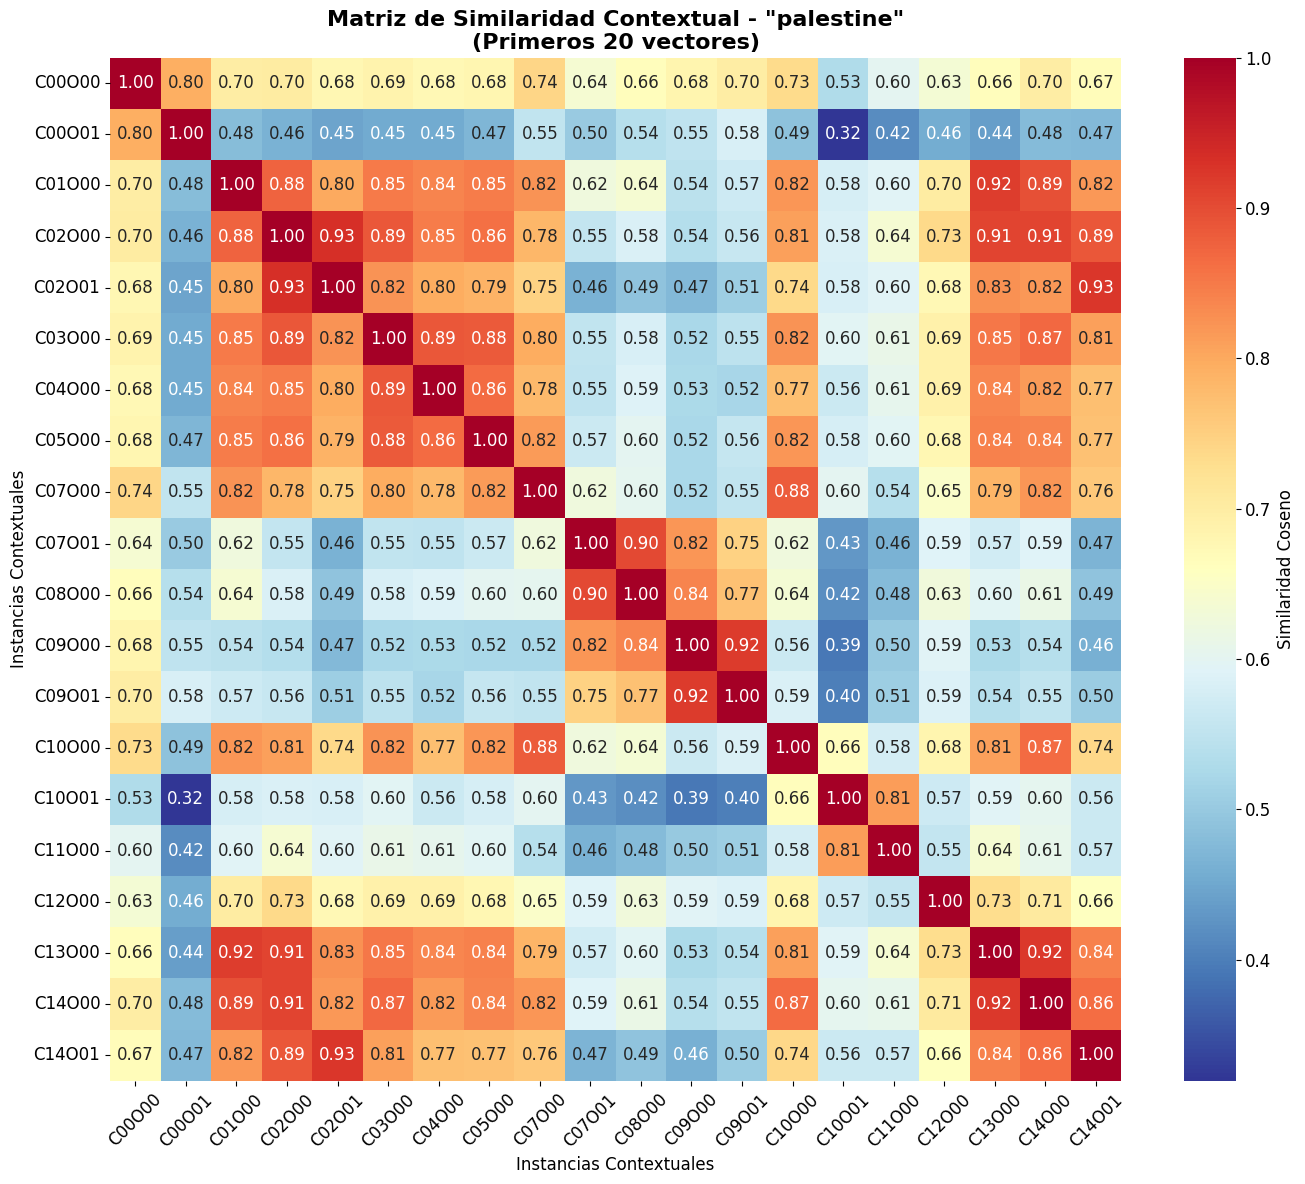

Similaridad promedio en la matriz: 0.6592


In [ ]:
# 2.1 Matriz de Similaridad Completa
if contour_data and analysis_results:
    # Extraer vectores contextuales (excluyendo el estático)
    contextual_vectors = []
    context_labels = []
    
    for key, data in contour_data.items():
        if key != 'static_vector' and isinstance(data, dict) and 'vector' in data:
            contextual_vectors.append(data['vector'])
            # Crear etiqueta descriptiva
            ctx_idx = data.get('context_index', 0)
            occ_idx = data.get('occurrence_index', 0)
            context_labels.append(f"C{ctx_idx:02d}O{occ_idx:02d}")
    
    n_vectors = len(contextual_vectors)
    print(f"Creando matriz de similaridad para {n_vectors} vectores contextuales")
    
    # Calcular matriz de similaridad completa
    similarity_matrix = np.zeros((n_vectors, n_vectors))
    for i in range(n_vectors):
        for j in range(n_vectors):
            if i == j:
                similarity_matrix[i, j] = 1.0
            else:
                sim = contours.cosine_similarity(contextual_vectors[i], contextual_vectors[j])
                similarity_matrix[i, j] = sim
    
    # Visualizar matriz con mapa de calor
    plt.figure(figsize=(14, 12))
    
    # Limitar a primeros 20 vectores para visualización clara
    max_display = min(20, n_vectors)
    display_matrix = similarity_matrix[:max_display, :max_display]
    display_labels = context_labels[:max_display]
    
    sns.heatmap(display_matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='RdYlBu_r',
                xticklabels=display_labels,
                yticklabels=display_labels,
                cbar_kws={'label': 'Similaridad Coseno'})
    
    plt.title(f'Matriz de Similaridad Contextual - "{target_word}"\n(Primeros {max_display} vectores)', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Instancias Contextuales', fontsize=12)
    plt.ylabel('Instancias Contextuales', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print(f"Similaridad promedio en la matriz: {np.mean(display_matrix[np.triu_indices_from(display_matrix, k=1)]):.4f}")
else:
    print("No hay datos para visualizar")

Aplicando t-SNE para visualización en 2D...


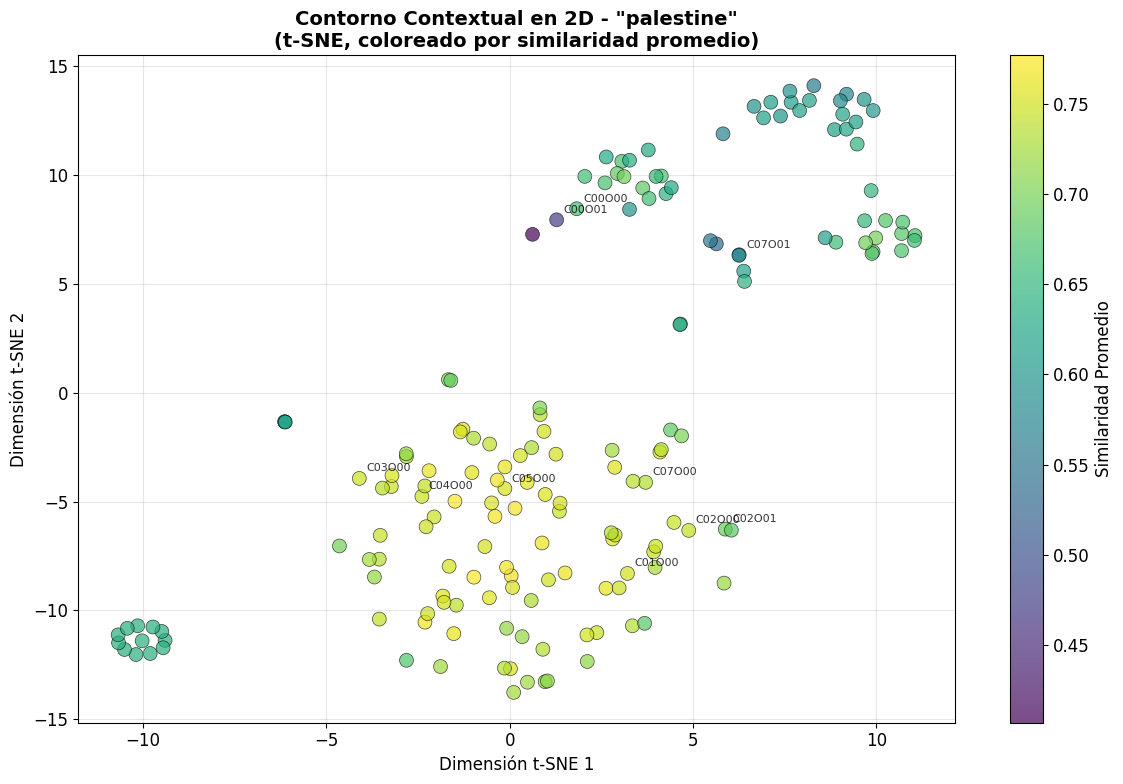

Varianza en similaridades: 0.004323
Rango de similaridades: 0.407 - 0.777


In [ ]:
# 2.2 Reducción Dimensional con t-SNE
if len(contextual_vectors) > 3:
    print("Aplicando t-SNE para visualización en 2D...")
    
    # Configurar t-SNE
    perplexity = min(30, len(contextual_vectors) - 1)
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, 
                n_iter=1000, learning_rate=200)
    
    # Aplicar t-SNE
    vectors_2d = tsne.fit_transform(np.array(contextual_vectors))
    
    # Crear visualización
    plt.figure(figsize=(12, 8))
    
    # Scatter plot con colores según similaridad promedio
    avg_similarities = []
    for i, vec in enumerate(contextual_vectors):
        # Calcular similaridad promedio con otros vectores
        similarities = [contours.cosine_similarity(vec, other_vec) 
                       for j, other_vec in enumerate(contextual_vectors) if i != j]
        avg_similarities.append(np.mean(similarities))
    
    scatter = plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], 
                         c=avg_similarities, cmap='viridis', 
                         s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Añadir etiquetas para algunos puntos
    for i in range(min(10, len(vectors_2d))):
        plt.annotate(context_labels[i], 
                    (vectors_2d[i, 0], vectors_2d[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.8)
    
    plt.colorbar(scatter, label='Similaridad Promedio')
    plt.title(f'Contorno Contextual en 2D - "{target_word}"\n(t-SNE, coloreado por similaridad promedio)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Dimensión t-SNE 1')
    plt.ylabel('Dimensión t-SNE 2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Varianza en similaridades: {np.var(avg_similarities):.6f}")
    print(f"Rango de similaridades: {np.min(avg_similarities):.3f} - {np.max(avg_similarities):.3f}")
else:
    print("Necesario al menos 4 vectores para t-SNE")

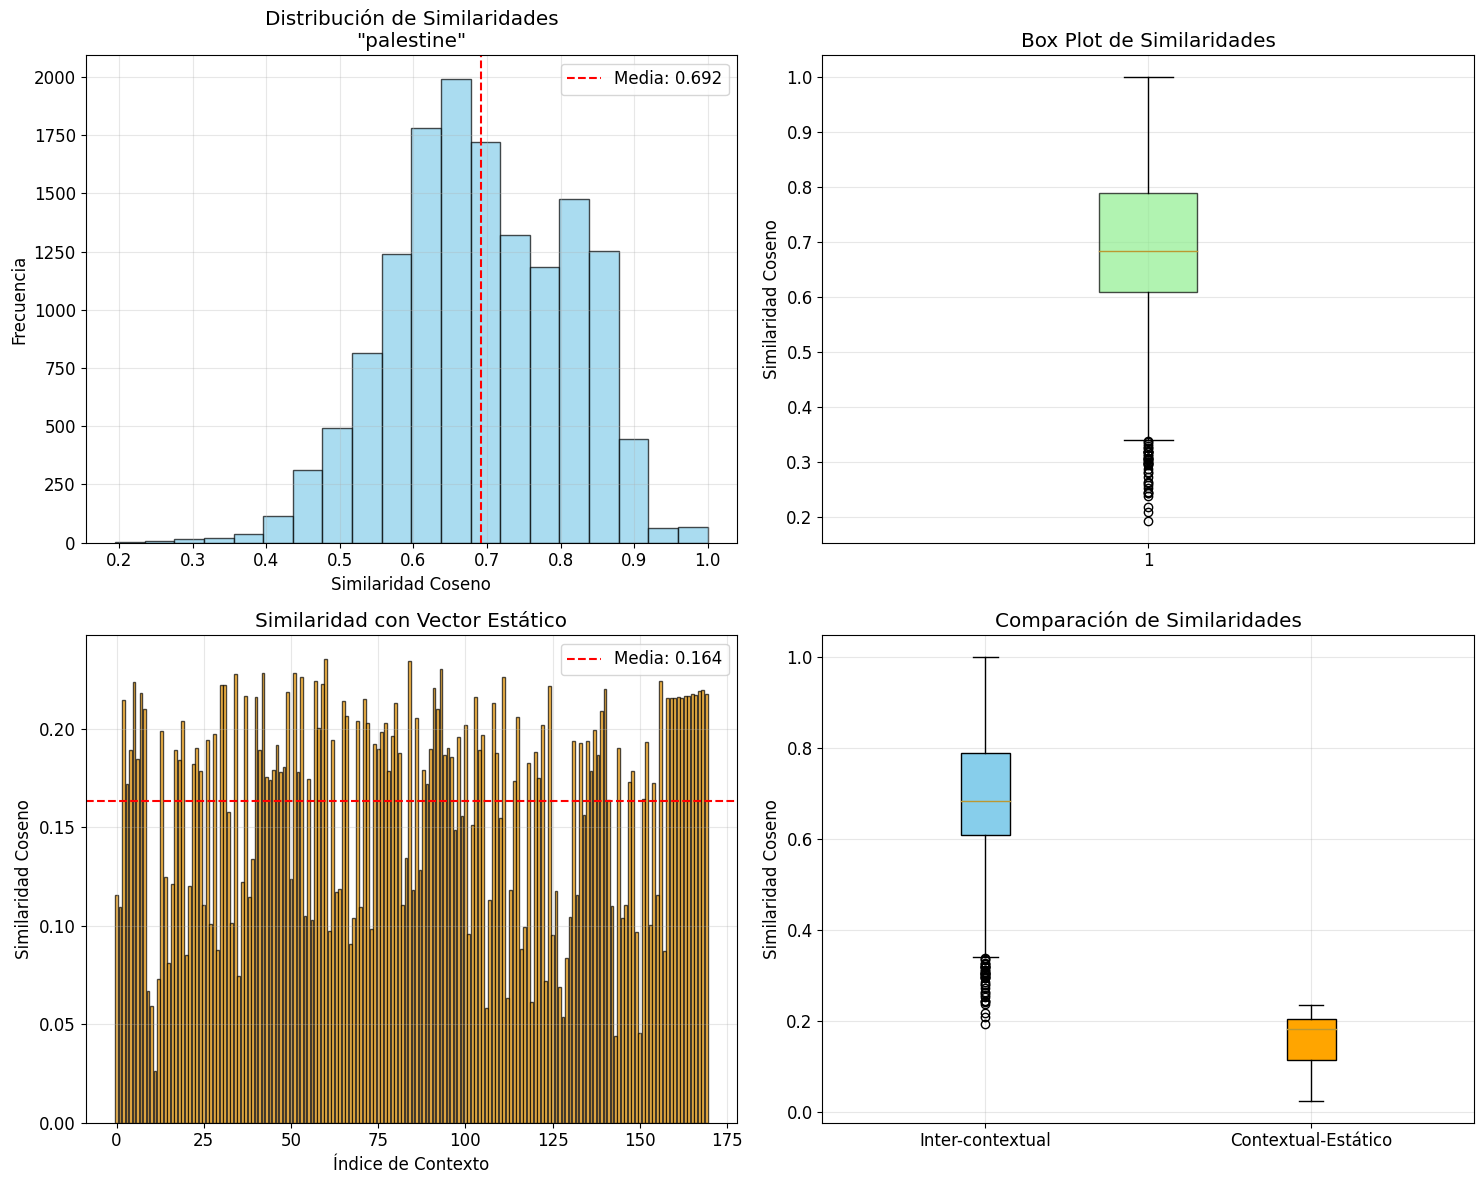

=== ESTADÍSTICAS DESCRIPTIVAS ===
Similaridades inter-contextuales:
  Media: 0.6915
  Mediana: 0.6839
  Desviación estándar: 0.1186
  Min: 0.1942
  Max: 0.9999


In [ ]:
# 2.3 Análisis de Distribución de Similaridades
if analysis_results:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Histograma de similaridades pairwise
    all_similarities = []
    n_ctx = len(contextual_vectors)
    for i in range(n_ctx):
        for j in range(i+1, n_ctx):
            sim = contours.cosine_similarity(contextual_vectors[i], contextual_vectors[j])
            all_similarities.append(sim)
    
    ax1.hist(all_similarities, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(np.mean(all_similarities), color='red', linestyle='--', 
                label=f'Media: {np.mean(all_similarities):.3f}')
    ax1.set_title(f'Distribución de Similaridades\n"{target_word}"')
    ax1.set_xlabel('Similaridad Coseno')
    ax1.set_ylabel('Frecuencia')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Box plot de similaridades
    ax2.boxplot(all_similarities, patch_artist=True, 
                boxprops=dict(facecolor='lightgreen', alpha=0.7))
    ax2.set_title('Box Plot de Similaridades')
    ax2.set_ylabel('Similaridad Coseno')
    ax2.grid(True, alpha=0.3)
    
    # 3. Similaridades con vector estático (si existe)
    if analysis_results['has_static'] and 'static_vector' in contour_data:
        static_sims = analysis_results['static_similarities']
        
        ax3.bar(range(len(static_sims)), static_sims, 
               color='orange', alpha=0.7, edgecolor='black')
        ax3.axhline(np.mean(static_sims), color='red', linestyle='--',
                   label=f'Media: {np.mean(static_sims):.3f}')
        ax3.set_title('Similaridad con Vector Estático')
        ax3.set_xlabel('Índice de Contexto')
        ax3.set_ylabel('Similaridad Coseno')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'Vector estático\nno disponible', 
                transform=ax3.transAxes, ha='center', va='center', fontsize=12)
        ax3.set_title('Vector Estático - No Disponible')
    
    # 4. Comparación contextual vs estático
    if analysis_results['has_static']:
        data_to_plot = [all_similarities, static_sims]
        labels = ['Inter-contextual', 'Contextual-Estático']
        
        bp = ax4.boxplot(data_to_plot, labels=labels, patch_artist=True)
        bp['boxes'][0].set_facecolor('skyblue')
        bp['boxes'][1].set_facecolor('orange')
        ax4.set_title('Comparación de Similaridades')
        ax4.set_ylabel('Similaridad Coseno')
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'Comparación no\ndisponible', 
                transform=ax4.transAxes, ha='center', va='center', fontsize=12)
        ax4.set_title('Comparación - No Disponible')
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas descriptivas
    print("=== ESTADÍSTICAS DESCRIPTIVAS ===")
    print(f"Similaridades inter-contextuales:")
    print(f"  Media: {np.mean(all_similarities):.4f}")
    print(f"  Mediana: {np.median(all_similarities):.4f}")
    print(f"  Desviación estándar: {np.std(all_similarities):.4f}")
    print(f"  Min: {np.min(all_similarities):.4f}")
    print(f"  Max: {np.max(all_similarities):.4f}")
else:
    print("No hay resultados de análisis para visualizar")

## 3. Análisis de Contextos Específicos

Examinemos algunos contextos específicos para entender mejor cómo varía el significado de la palabra:

In [ ]:
# 3.1 Examinar contextos más y menos similares
if contour_data and len(contextual_vectors) > 1:
    # Calcular similaridades promedio para cada vector
    vector_similarities = []
    for i, vec_i in enumerate(contextual_vectors):
        similarities = []
        for j, vec_j in enumerate(contextual_vectors):
            if i != j:
                sim = contours.cosine_similarity(vec_i, vec_j)
                similarities.append(sim)
        avg_sim = np.mean(similarities)
        vector_similarities.append((i, avg_sim))
    
    # Ordenar por similaridad
    vector_similarities.sort(key=lambda x: x[1])
    
    print("=== ANÁLISIS DE CONTEXTOS ESPECÍFICOS ===\n")
    
    # Mostrar contextos menos similares (más únicos)
    print("🔸 CONTEXTOS MÁS ÚNICOS (menor similaridad promedio):")
    for i in range(min(3, len(vector_similarities))):
        idx, avg_sim = vector_similarities[i]
        key = list(contour_data.keys())[idx] if idx < len(contour_data) - 1 else list(contour_data.keys())[idx+1]
        if key != 'static_vector' and isinstance(contour_data[key], dict):
            context = contour_data[key]['context']
            word_pos = contour_data[key]['position']
            words = context.split()
            
            # Destacar la palabra objetivo
            highlighted_context = []
            for j, word in enumerate(words):
                if j == word_pos:
                    highlighted_context.append(f"**{word}**")
                else:
                    highlighted_context.append(word)
            
            print(f"  {i+1}. Similaridad promedio: {avg_sim:.3f}")
            print(f"     Contexto: {' '.join(highlighted_context[:15])}...")
            print()
    
    # Mostrar contextos más similares (más típicos)
    print("🔸 CONTEXTOS MÁS TÍPICOS (mayor similaridad promedio):")
    for i in range(min(3, len(vector_similarities))):
        idx, avg_sim = vector_similarities[-(i+1)]
        key = list(contour_data.keys())[idx] if idx < len(contour_data) - 1 else list(contour_data.keys())[idx+1]
        if key != 'static_vector' and isinstance(contour_data[key], dict):
            context = contour_data[key]['context']
            word_pos = contour_data[key]['position']
            words = context.split()
            
            # Destacar la palabra objetivo
            highlighted_context = []
            for j, word in enumerate(words):
                if j == word_pos:
                    highlighted_context.append(f"**{word}**")
                else:
                    highlighted_context.append(word)
            
            print(f"  {i+1}. Similaridad promedio: {avg_sim:.3f}")
            print(f"     Contexto: {' '.join(highlighted_context[:15])}...")
            print()
    
    # Análisis de varianza
    similarities_variance = np.var([sim for _, sim in vector_similarities])
    print(f"🔸 VARIANZA EN SIMILARIDADES: {similarities_variance:.6f}")
    if similarities_variance > 0.01:
        print("   → Alta varianza: La palabra muestra significados muy diversos")
    elif similarities_variance > 0.005:
        print("   → Varianza moderada: La palabra tiene algunos usos diferentes")
    else:
        print("   → Baja varianza: La palabra es relativamente consistente en significado")
else:
    print("No hay suficientes vectores para análisis detallado")

=== ANÁLISIS DE CONTEXTOS ESPECÍFICOS ===

🔸 CONTEXTOS MÁS ÚNICOS (menor similaridad promedio):
  1. Similaridad promedio: 0.407
     Contexto: Palestine's founding document is the Palestinian Declaration of Independence, which should be distinguished from the...

  2. Similaridad promedio: 0.474
     Contexto: Palestine, officially the State of **Palestine,** is a country in West Asia....

  3. Similaridad promedio: 0.533
     Contexto: In the 5th century BCE, in his work The Histories, Herodotus used the term to...

🔸 CONTEXTOS MÁS TÍPICOS (mayor similaridad promedio):
  1. Similaridad promedio: 0.777
     Contexto: As few parts of the city is also under Palestinian control and many some countries...

  2. Similaridad promedio: 0.774
     Contexto: Popular Front for the Liberation of **Palestine** is another popular secular party, which was founded...

  3. Similaridad promedio: 0.772
     Contexto: The existence of a state of **Palestine** is recognized by the states that have estab

## 4. Interpretación y Conclusiones

Basándose en el análisis del contorno contextual, podemos extraer insights sobre la polisemia y variación semántica de la palabra:

In [ ]:
# 4.1 Resumen del Análisis del Contorno Contextual
if analysis_results:
    print("=" * 60)
    print(f"RESUMEN DEL CONTORNO CONTEXTUAL: '{target_word.upper()}'")
    print("=" * 60)
    
    # Métricas principales
    n_vectors = analysis_results['n_contextual_vectors']
    mean_sim = analysis_results['mean_contextual_similarity']
    sim_std = analysis_results['similarity_std']
    sim_range = analysis_results['similarity_range']
    
    print(f"📊 MÉTRICAS BÁSICAS:")
    print(f"   • Instancias contextuales extraídas: {n_vectors}")
    print(f"   • Similaridad inter-contextual promedio: {mean_sim:.4f}")
    print(f"   • Desviación estándar: {sim_std:.4f}")
    print(f"   • Rango de similaridad: {sim_range:.4f}")
    print()
    
    # Interpretación automática
    print(f"🔍 INTERPRETACIÓN AUTOMÁTICA:")
    
    # Variación semántica
    if sim_std > 0.15:
        variation_level = "ALTA"
        interpretation = "La palabra muestra significados muy diversos en diferentes contextos"
    elif sim_std > 0.08:
        variation_level = "MODERADA"
        interpretation = "La palabra tiene variación semántica notable pero controlada"
    else:
        variation_level = "BAJA"
        interpretation = "La palabra mantiene significado relativamente consistente"
    
    print(f"   • Variación semántica: {variation_level}")
    print(f"   • {interpretation}")
    print()
    
    # Coherencia contextual
    if mean_sim > 0.75:
        coherence_level = "ALTA"
        coherence_desc = "Los diferentes usos están estrechamente relacionados"
    elif mean_sim > 0.6:
        coherence_level = "MODERADA"
        coherence_desc = "Los usos muestran relación semántica moderada"
    else:
        coherence_level = "BAJA"
        coherence_desc = "Los usos pueden representar significados distintos"
    
    print(f"   • Coherencia contextual: {coherence_level}")
    print(f"   • {coherence_desc}")
    print()
    
    # Comparación con vector estático
    if analysis_results['has_static']:
        static_mean = analysis_results['mean_static_similarity']
        print(f"📈 COMPARACIÓN CON REPRESENTACIÓN ESTÁTICA:")
        if static_mean > mean_sim:
            print(f"   • El vector estático es MÁS similar a los contextos ({static_mean:.3f} vs {mean_sim:.3f})")
            print(f"   • Sugiere que la representación estática captura bien el significado promedio")
        else:
            print(f"   • Los contextos son MÁS similares entre sí que al vector estático")
            print(f"   • Sugiere alta especialización contextual")
    
    print()
    print(f"🎯 CONCLUSIÓN PRINCIPAL:")
    if variation_level == "ALTA" and coherence_level == "BAJA":
        conclusion = f"'{target_word}' es altamente polisémico con significados distintivos"
    elif variation_level == "ALTA" and coherence_level in ["MODERADA", "ALTA"]:
        conclusion = f"'{target_word}' muestra flexibilidad semántica manteniendo coherencia"
    elif variation_level == "MODERADA":
        conclusion = f"'{target_word}' tiene variación semántica controlada y predecible"
    else:
        conclusion = f"'{target_word}' mantiene significado estable a través de contextos"
    
    print(f"   {conclusion}")
    print("=" * 60)
else:
    print("No hay resultados para interpretar")

RESUMEN DEL CONTORNO CONTEXTUAL: 'PALESTINE'
📊 MÉTRICAS BÁSICAS:
   • Instancias contextuales extraídas: 170
   • Similaridad inter-contextual promedio: 0.6915
   • Desviación estándar: 0.1186
   • Rango de similaridad: 0.8057

🔍 INTERPRETACIÓN AUTOMÁTICA:
   • Variación semántica: MODERADA
   • La palabra tiene variación semántica notable pero controlada

   • Coherencia contextual: MODERADA
   • Los usos muestran relación semántica moderada

📈 COMPARACIÓN CON REPRESENTACIÓN ESTÁTICA:
   • Los contextos son MÁS similares entre sí que al vector estático
   • Sugiere alta especialización contextual

🎯 CONCLUSIÓN PRINCIPAL:
   'palestine' tiene variación semántica controlada y predecible


## 5. Exploración con Diferentes Palabras

Podemos probar el análisis con diferentes palabras para comparar sus contornos contextuales. Algunas sugerencias:

- **Palabras polisémicas**: `bank`, `bark`, `bat`, `crane`, `spring`
- **Palabras técnicas**: `virus`, `cell`, `field`, `current`
- **Palabras abstractas**: `love`, `freedom`, `justice`, `beauty`
- **Palabras concretas**: `table`, `house`, `car`, `tree`

Simplemente cambiamos la variable `target_word`.